# Spectral similarity visualisation

In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt

# custom
from reflectance import spectrum_utils, plotting, file_ops, optimisation_pipeline

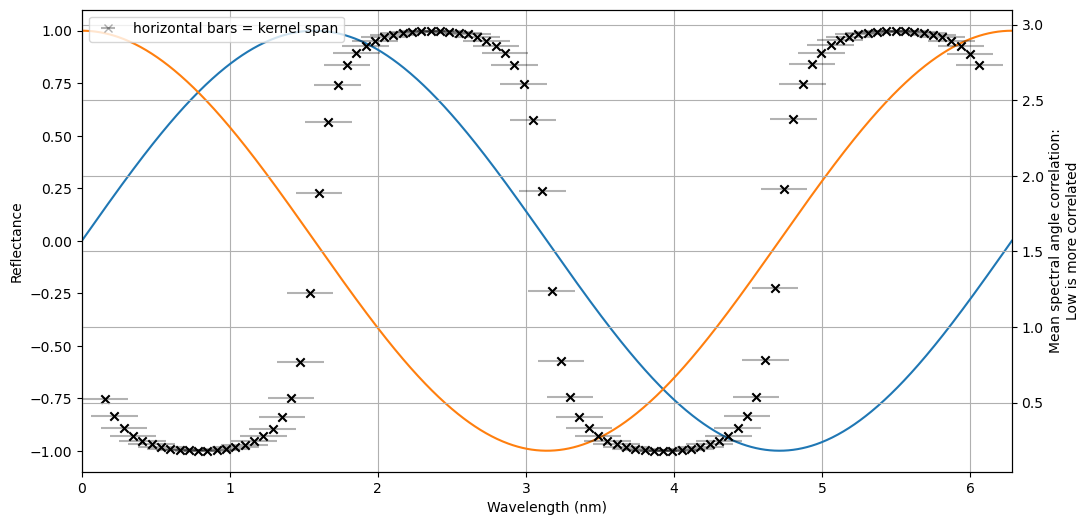

In [22]:
### Spectral angle
# checking that spectral angle calculation/plot is correct
xs = np.linspace(0, 2*np.pi, 1000)

kernel_width = 0.1*np.pi
kernel_displacement = 0.02*np.pi

curve_dict = {
    'sin': pd.Series(np.sin(xs), index=xs),
    # 'sin2': pd.Series(10*np.sin(xs), index=xs),
    'cos': pd.Series(np.cos(xs), index=xs),
}

wv_pairs, mean_corrs = spectrum_utils.calc_rolling_similarity(xs, np.array([curve_dict[k].values for k in curve_dict.keys()]), kernel_width, kernel_displacement, spectrum_utils.spectral_angle)

plotting.plot_rolling_spectral_similarity(wv_pairs, mean_corrs, xs, curve_dict.values())


# Change in similarity with parameters

In [47]:
endmember_arrray.loc[:, sensor_range[0]:sensor_range[1]]

,452.642775,455.475056,458.307394,461.139788,463.972238,466.804744,469.637306,472.469925,475.302600,478.135331,...,662.383497,665.219940,668.056439,670.892995,673.729607,676.566275,679.402999,682.239779,685.076616,687.913509
class,,,,,,,,,,,,,,,,,,,,,
CCA,0.047885,0.048498,0.048926,0.049247,0.049562,0.049950,0.050420,0.050921,0.051362,0.051658,...,0.080434,0.074011,0.068520,0.064358,0.061682,0.060564,0.061143,0.063754,0.068874,0.076957
algae,0.028979,0.029437,0.029773,0.030059,0.030359,0.030713,0.031106,0.031495,0.031832,0.032097,...,0.048428,0.045457,0.043014,0.041333,0.040538,0.040705,0.041944,0.044484,0.048674,0.054881
coral,0.030705,0.030943,0.031128,0.031400,0.031850,0.032535,0.033420,0.034409,0.035405,0.036325,...,0.055484,0.049621,0.045204,0.042521,0.041496,0.042002,0.044309,0.049318,0.058494,0.073355
sand,0.052638,0.052914,0.053111,0.053317,0.053582,0.053932,0.054332,0.054722,0.055073,0.055394,...,0.088468,0.087054,0.085804,0.084929,0.084587,0.084857,0.085776,0.087355,0.089554,0.092270


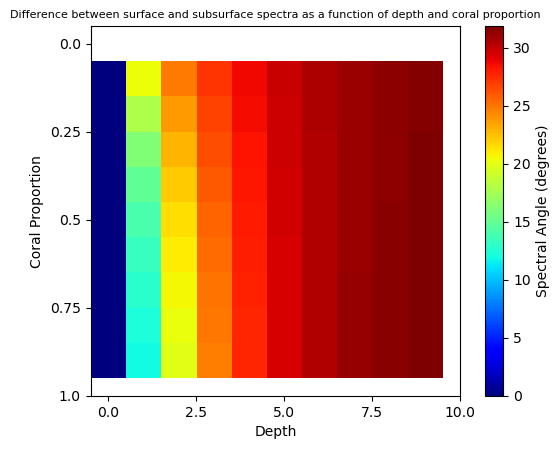

In [69]:
n_samples = 10
max_depth = 10
sensor_range = [450, 690]

depths = np.linspace(0, max_depth, n_samples)
coral_props = np.linspace(0, 1, n_samples)
angles = np.zeros((len(depths), len(coral_props)))

bb = np.mean((0, 0.41123))
K = np.mean((0.01688, 3.17231))
Rb_values = (0, 0, 0, 0)    # algae, CCA, coral, sand

endmember_class_schema = "four_endmember"
glob_cfg, _ = file_ops.instantiate_single_configs_instance(run_ind = 0)
# generate endmember array
endmember_array = optimisation_pipeline.GenerateEndmembers(
    endmember_class_map=glob_cfg.endmember_schema[endmember_class_schema],
    endmember_dimensionality_reduction="mean",
).generate_endmembers()
# crop to sensor range
endmember_array = endmember_array.loc[:,sensor_range[0]:sensor_range[1]]


AOP_model = spectrum_utils.load_aop_model(aop_group_num=1).loc[sensor_range[0]:sensor_range[1]]
wvs = AOP_model.index
AOP_sub = AOP_model.loc[wvs]
AOP_args = (AOP_sub.bb_m.values, AOP_sub.bb_c.values, AOP_sub.Kd_m.values, AOP_sub.Kd_c.values)

# read in spectral library
f = file_ops.RESOURCES_DIR_FP / "spectral_library_clean_v3_PRISM_wavebands.csv"
df = pd.read_csv(f, skiprows=1).set_index('wavelength')
df.columns = df.columns.astype(float)
df = df.astype(float)


# Precompute surface spectra for all coral proportions
surface_spectra = np.array([
    spectrum_utils.sub_surface_reflectance_Rb(wvs, endmember_array, bb, K, 0, AOP_args, 0, 0, Rb2, 0)
    for Rb2 in coral_props
])

# Iterate over depths and coral proportions
for j, H in enumerate(depths):
    for i, Rb2 in enumerate(coral_props):
        retrieved_spectrum = spectrum_utils.sub_surface_reflectance_Rb(wvs, endmember_array, bb, K, H, AOP_args, 0, 0, Rb2, 0)
        angle = spectrum_utils.spectral_angle(retrieved_spectrum, surface_spectra[i])
        angles[i, j] = np.degrees(angle) if not np.isnan(angle) else np.nan

plt.title("Difference between surface and subsurface spectra as a function of depth and coral proportion", fontsize=8)
plt.imshow(angles, cmap='jet')
plt.ylabel("Coral Proportion")
plt.xlabel("Depth")
plt.colorbar(label="Spectral Angle (degrees)")
# set x and y ticks to actual values
plt.yticks(np.linspace(0, n_samples, 5), np.round(np.linspace(0, 1, 5), 2))
plt.xticks(np.linspace(0, n_samples, 5), np.round(np.linspace(0, 10, 5), 2));

In [65]:
np.zeros((len(depths), len(coral_props), len(metrics))).shape

(100, 100, 4)

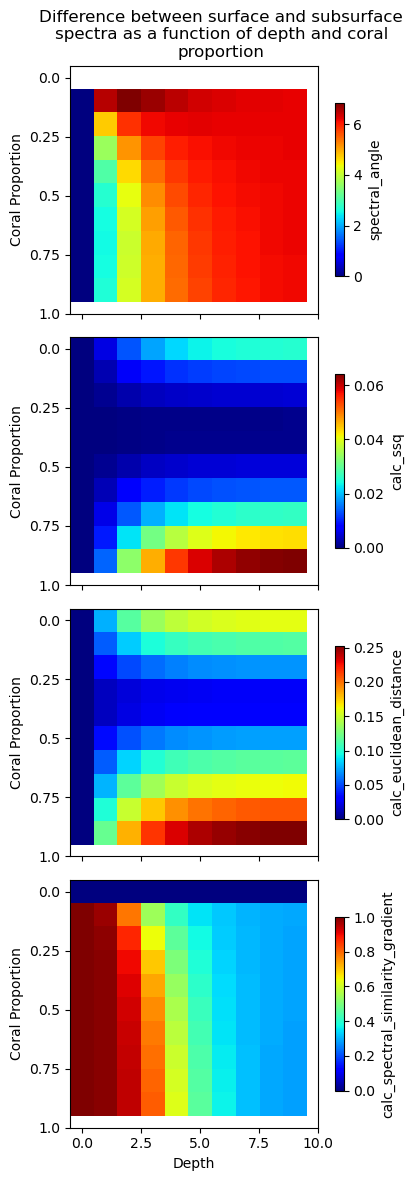

In [114]:
from tqdm.auto import tqdm


wv_range = [600, 700]


# Precompute surface spectra for all coral proportions
surface_spectra = [
    spectrum_utils.sub_surface_reflectance_Rb(wvs, endmember_array, bb, K, 0, AOP_args, 0, 0, Rb2, 0).loc[min(wv_range):max(wv_range)] if wv_range else retrieved_spectrum
    for Rb2 in coral_props
]

metrics = [spectrum_utils.spectral_angle, spectrum_utils.calc_ssq, spectrum_utils.calc_euclidean_distance, spectrum_utils.calc_spectral_similarity_gradient]

fig, axes = plt.subplots(len(metrics), 1, figsize=(4, 3*len(metrics)), sharex=True, sharey=True)

results = np.zeros((len(depths), len(coral_props), len(metrics)))

# Iterate over depths and coral proportions
# for j, H in tqdm(enumerate(depths), total=len(depths)):
for j, H in enumerate(depths):
    for i, Rb2 in enumerate(coral_props):
        retrieved_spectrum = spectrum_utils.sub_surface_reflectance_Rb(wvs, endmember_array, bb, K, H, AOP_args, 0, 0, Rb2, 0)
        for m, metric in enumerate(metrics):
            res = metric(
                retrieved_spectrum.loc[min(wv_range):max(wv_range)] if wv_range else retrieved_spectrum, 
                surface_spectra[i])
            if metric == spectrum_utils.spectral_angle:
                res = np.degrees(res) if not np.isnan(res) else np.nan
            results[i, j, m] = res


for ax_i, ax in enumerate(axes):
    im = ax.imshow(results[:, :, ax_i], cmap='jet')
    ax.set_ylabel("Coral Proportion")
    ax.set_yticks(np.linspace(0, n_samples, 5), np.round(np.linspace(0, 1, 5), 2))
    ax.set_xticks(np.linspace(0, n_samples, 5), np.round(np.linspace(0, 10, 5), 2));
    fig.colorbar(im, ax=ax, label=metrics[ax_i].__name__, shrink=0.7)
    
ax.set_xlabel("Depth")
plt.suptitle("Difference between surface and subsurface spectra as a function of depth and coral proportion", fontsize=12, wrap=True)
# # set x and y ticks to actual values
plt.tight_layout()

In [ ]:
# ANIMATION

# slider to vary depth
# triangular slider to vary benthic proportions
# third slider to vary wavelength range for which metric is calculated.
# some other menu/slider to vary metric.

# for each configuration:
# plot received spectrum at surface (will depend on coral proportion)
# plot received spectrum at depth
# on twin axis, plot difference between the two spectra according to the selected metric.


NameError: name 'ax_spectrum' is not defined

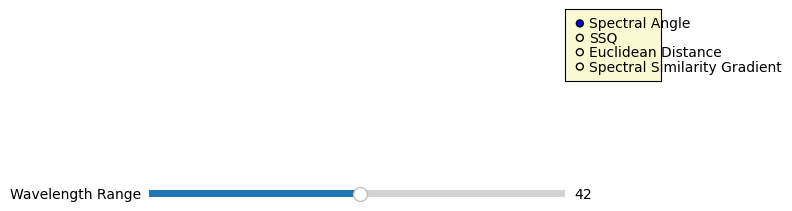

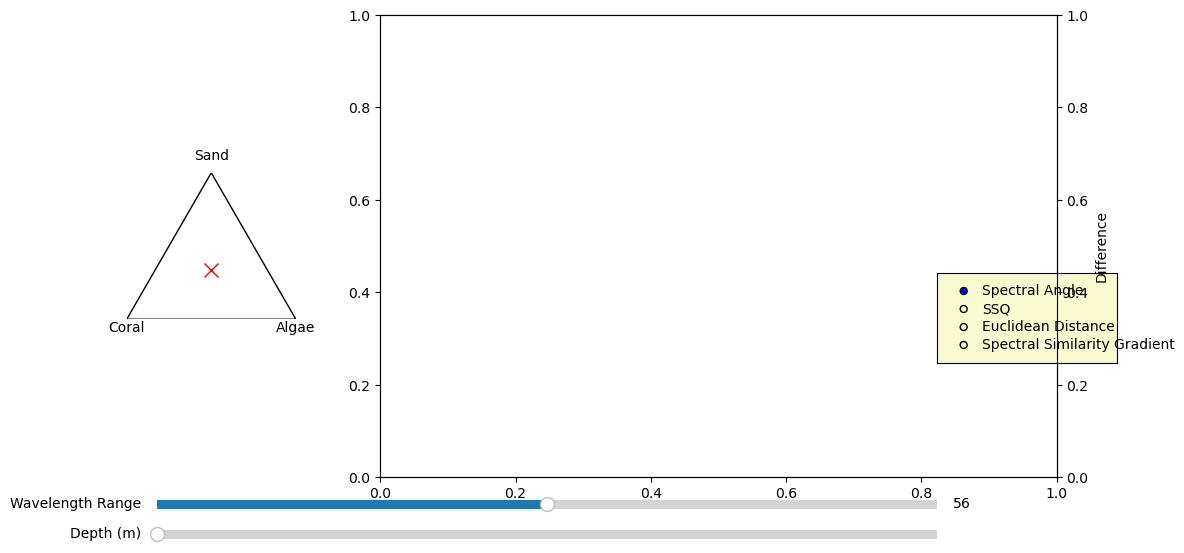

In [2]:
import numpy as np

# general
import numpy as np

# plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.widgets import Slider
from matplotlib.path import Path as pPath
from matplotlib.widgets import Slider, RadioButtons

# custom
from reflectance import file_ops, spectrum_utils



# Load fractional spectra
frac_spectra = np.load(file_ops.TMP_DIR_FP / "fractional_spectra.npy")
wvs = np.load(file_ops.TMP_DIR_FP / "wavelengths.npy")
fracs = np.load(file_ops.TMP_DIR_FP / "fracs.npy")

# Define the vertices of the triangle (100% coral, algae, sand)
triangle = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3) / 2]])

MAX_DEPTH = 10  # maximum depth in meters   # TODO: make this less hard-coded
# Define the colours for the three components (vertices)
COLOURS = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])


def get_proportions(point: tuple[float, float], triangle: tuple[tuple[float, float]]):
    """Calculate barycentric coordinates (https://mathworld.wolfram.com/BarycentricCoordinates.html)
    of a point within a triangle."""

    def area(p1: tuple[float, float], p2: tuple[float, float], p3: tuple[float, float]):
        """Calculate area of triangle given 3 points."""
        return 0.5 * abs(
            p1[0] * (p2[1] - p3[1]) + p2[0] * (p3[1] - p1[1]) + p3[0] * (p1[1] - p2[1])
        )

    total_area = area(*triangle)
    coral_prop = area(point, triangle[1], triangle[2]) / total_area
    algae_prop = area(point, triangle[2], triangle[0]) / total_area
    sand_prop = area(point, triangle[0], triangle[1]) / total_area

    return coral_prop, algae_prop, sand_prop


def closest_point_in_triangle(
    point: tuple[float, float], triangle: tuple[tuple[float, float]]
):
    """In the event that the point is outside the triangle, find the closest point on the triangle."""
    path = pPath(triangle)
    if path.contains_point(point):
        return point
    else:
        # Project point onto the nearest edge of the triangle
        min_distance = float("inf")
        closest_point = None  # store closest point
        for i in range(3):  # iterate over triangle edges
            v0, v1 = triangle[i], triangle[(i + 1) % 3]  # get vertices
            projection = np.dot(point - v0, v1 - v0) / np.linalg.norm(v1 - v0) ** 2
            projection = np.clip(projection, 0, 1)
            proj_point = v0 + projection * (v1 - v0)
            distance_to_proj = np.linalg.norm(point - proj_point)
            # check that this is the closest point to any of the sides yet
            if distance_to_proj < min_distance:
                min_distance = distance_to_proj
                closest_point = proj_point
        return closest_point


def update_spectrum(val):
    """Update spectrum plot based on slider value."""
    depth = slider_depth.val
    depths = np.linspace(0, MAX_DEPTH, frac_spectra.shape[3])
    # make sure the depth index is within bounds
    depth = np.clip(depth, 0, frac_spectra.shape[3] - 1)

    coral_prop, algae_prop, sand_prop = get_proportions([point_x, point_y], triangle)
    # find the closest spectrum for the given proportion
    coral_index = np.argmin(np.abs(fracs - coral_prop))
    algae_index = np.argmin(np.abs(fracs - algae_prop))
    sand_index = np.argmin(np.abs(fracs - sand_prop))

    nearest_spectrum = frac_spectra[coral_index, algae_index, sand_index, depth]

    # generate grid of colours within the triangle
    # spectrum_colours = generate_triangle_grid_colours(n_points=100)
    # mix the colours based on barycentric coordinates
    spectrum_colour = np.clip(
        np.dot((coral_prop, algae_prop, sand_prop), COLOURS), 0, 1
    )

    # update and format the spectrum plot
    ax_spectrum.clear()
    ax_spectrum.set_ylim(0, 0.1)
    ax_spectrum.set_xlim(wvs[0], wvs[-1])
    ax_spectrum.plot(wvs, nearest_spectrum, color=spectrum_colour)
    ax_spectrum.set_title(
        f"Nearest Spectrum: Coral {coral_prop:.2f}, Algae {algae_prop:.2f}, Sand {sand_prop:.2f}, Depth {depths[depth]:.2f}m",
        pad=10,
    )
    ax_spectrum.set_xlabel("Wavelength (nm)")
    ax_spectrum.set_ylabel("Reflectance")
    fig.canvas.draw_idle()


def on_drag(event: matplotlib.backend_bases.MouseEvent):
    """
    Handle mouse drag event to update the position of a point within a triangle and
    display the corresponding proportions of coral, algae, and sand.

    Parameters:
    event (matplotlib.backend_bases.MouseEvent): The mouse event containing information
    about the drag action, including the new coordinates of the point.

    Returns:
    None
    """
    """Handle mouse drag event."""
    global point_x, point_y  # store coordinates of point being dragged globally
    if event.inaxes == ax:  # if outside axes, do nothing
        new_point_x, new_point_y = event.xdata, event.ydata
        new_point = np.array([new_point_x, new_point_y])
        # constrain point to within triangle
        constrained_point = closest_point_in_triangle(new_point, triangle)
        point_x, point_y = constrained_point
        point.set_data([point_x], [point_y])
        coral_prop, algae_prop, sand_prop = get_proportions(
            [point_x, point_y], triangle
        )
        # proportion_text.set_text(
        #     f"Coral: {coral_prop:.2f}, Algae: {algae_prop:.2f}, Sand: {sand_prop:.2f}"
        # )
        update_spectrum(slider_depth.val)


# initialize plot
fig, (ax, ax_spectrum) = plt.subplots(1, 2, figsize=(12, 6), width_ratios=[1, 4])
# format
ax.set_aspect("equal")
ax.spines[["bottom", "top", "left", "right"]].set_visible(False)
ax.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
ax.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.5 * np.tan(np.pi / 3))

# draw triangle
tri_patch = Polygon(triangle, closed=True, fill=None, edgecolor="black")
ax.add_patch(tri_patch)
# set initial point as centre of triangle
point_x, point_y = 0.5, np.sqrt(3) / 6
(point,) = ax.plot([point_x], [point_y], "rx", markersize=10)

# triangle proportions text
proportion_text = ax.text(0.2, -0.2, "", transform=ax.transAxes)
# label triangle vertices
ax.text(0, -0.05, "Coral", ha="center", va="center")
ax.text(1, -0.05, "Algae", ha="center", va="center")
ax.text(0.5, 0.1 + np.sqrt(3) / 2, "Sand", ha="center", va="center")

# depth slider
ax_slider_depth = plt.axes([0.15, 0, 0.65, 0.03], facecolor="lightgoldenrodyellow")
slider_depth = Slider(
    ax_slider_depth, "Depth (m)", 0, frac_spectra.shape[3] - 1, valinit=0, valstep=1
)
slider_depth.valtext.set_visible(False)

# connect mouse movement over figure to on_drag function
fig.canvas.mpl_connect("motion_notify_event", on_drag)
# connect slider movement to update_spectrum function
slider_depth.on_changed(update_spectrum)

fig.canvas.manager.set_window_title('')  # Remove window title

# Define metrics for the difference plot
metrics = {
    "Spectral Angle": spectrum_utils.spectral_angle,
    "SSQ": spectrum_utils.calc_ssq,
    "Euclidean Distance": spectrum_utils.calc_euclidean_distance,
    "Spectral Similarity Gradient": spectrum_utils.calc_spectral_similarity_gradient,
}

# Add a second slider for wavelength range
ax_slider_wavelength = plt.axes([0.15, 0.05, 0.65, 0.03], facecolor="lightgoldenrodyellow")
slider_wavelength = Slider(
    ax_slider_wavelength, "Wavelength Range", 0, wvs.shape[0] - 1, valinit=wvs.shape[0] // 2, valstep=1
)

# Add a radio button menu to toggle metrics
ax_radio_metrics = plt.axes([0.8, 0.3, 0.15, 0.15], facecolor="lightgoldenrodyellow")
radio_metrics = RadioButtons(ax_radio_metrics, list(metrics.keys()), active=0)

def update_spectrum_with_metric(val):
    """Update the spectrum and metric plot based on slider and metric values."""
    depth = slider_depth.val
    depths = np.linspace(0, MAX_DEPTH, frac_spectra.shape[3])
    coral_prop, algae_prop, sand_prop = get_proportions([point_x, point_y], triangle)

    # Find the closest spectrum for the given proportion
    coral_index = np.argmin(np.abs(fracs - coral_prop))
    algae_index = np.argmin(np.abs(fracs - algae_prop))
    sand_index = np.argmin(np.abs(fracs - sand_prop))

    # Get surface and depth spectra
    surface_spectrum = frac_spectra[coral_index, algae_index, sand_index, 0]
    depth_spectrum = frac_spectra[coral_index, algae_index, sand_index, int(depth)]

    # Get wavelength range from slider
    wavelength_range = int(slider_wavelength.val)
    surface_spectrum = surface_spectrum[:wavelength_range]
    depth_spectrum = depth_spectrum[:wavelength_range]
    current_wvs = wvs[:wavelength_range]

    # Clear plots
    ax_spectrum.clear()
    ax_diff.clear()

    # Plot surface and depth spectra
    ax_spectrum.plot(current_wvs, surface_spectrum, color='blue', label='Surface')
    ax_spectrum.plot(current_wvs, depth_spectrum, color='red', label=f'Depth: {depth:.2f}m')
    ax_spectrum.legend()

    # Calculate and plot the difference using the selected metric
    selected_metric = radio_metrics.value_selected
    metric_function = metrics[selected_metric]
    metric_diff = metric_function(surface_spectrum, depth_spectrum)

    ax_diff.plot(current_wvs, metric_diff, color='green')
    ax_diff.set_title(f'Difference using {selected_metric}')

    fig.canvas.draw_idle()

# Initialize twin axis for the difference plot
ax_diff = ax_spectrum.twinx()
ax_diff.set_ylabel("Difference")

# Connect events to functions
slider_depth.on_changed(update_spectrum_with_metric)
slider_wavelength.on_changed(update_spectrum_with_metric)
radio_metrics.on_clicked(update_spectrum_with_metric)

# Show the plot
plt.show(block=False)